In [1]:
import h5py
import matplotlib.pyplot as plt
from collections import Counter
from data import Vocabulary
import numpy as np
from tqdm import tqdm

In [2]:
f = open("data/books_large.txt")
data = f.readlines()

In [3]:
counter = Counter()
for d in data:
    counter[len(d.split())] += 1

Sentences longer than 100 tokens: 11113


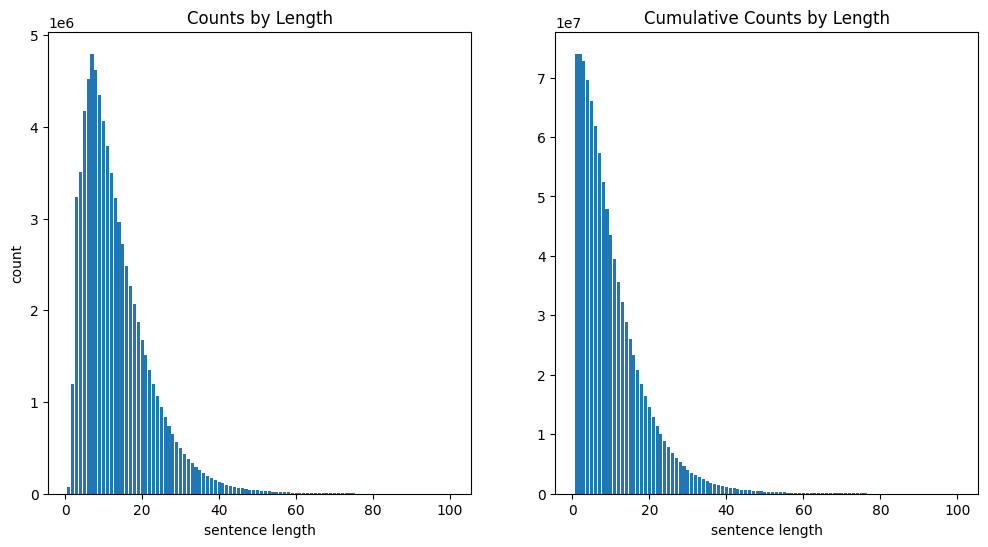

In [4]:
sorted_items = sorted(counter.items(), key=lambda x: x[0])
lengths, counts = zip(*sorted_items)
sums = [sum(counts[i:]) for i in range(len(lengths))]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].bar(lengths[:100], counts[:100])
axs[0].set_title("Counts by Length")
axs[0].set_xlabel("sentence length")
axs[0].set_ylabel("count")

axs[1].bar(lengths[:100], sums[:100])
axs[1].set_title("Cumulative Counts by Length")
axs[1].set_xlabel("sentence length")

print(f"Sentences longer than 100 tokens: {sum(counts[100:])}")

In [5]:
min_seq_len = 5
max_seq_len = 100

valid_size = 1e5
test_size = 1e5

vocab = Vocabulary.load("data/vocab.json")
indices = np.arange(len(data))
np.random.shuffle(indices)

with h5py.File("data/pretraining_split.h5", "w") as h5f:
    dt = h5py.special_dtype(vlen=int)
    valid_ds = h5f.create_dataset("validation", shape=(valid_size,), dtype=dt, chunks=True)
    test_ds = h5f.create_dataset("test", shape=(test_size,), dtype=dt, chunks=True)
    training_ds = h5f.create_dataset("training", shape=(len(data) - valid_size - test_size,), dtype=dt, chunks=True, maxshape=(None,))
    
    count_valid = count_test = count_train  = 0
    for idx in tqdm(indices):
        wrd_indices = vocab.words_to_indices(data[idx].split())
        
        if len(wrd_indices) < min_seq_len or len(wrd_indices) > max_seq_len:
            continue

        if count_valid < valid_size:
            valid_ds[count_valid] = wrd_indices
            count_valid += 1
        elif count_test < test_size:
            test_ds[count_test] = wrd_indices
            count_test += 1
        else:
            training_ds[count_train] = wrd_indices
            count_train += 1
    
    training_ds.resize((count_train,)) # since we filtered out some sentences, resize to the actual size

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 74004228/74004228 [1:30:24<00:00, 13641.36it/s]


100000.0

In [28]:
with h5py.File("data/pretraining_split.h5", "r") as h5f:
    valid_ds = h5f["validation"]
    unk_index = vocab.word_to_index[vocab.unk_token]
    total_unk = 0
    total = 0
    for wrd_indices in valid_ds:
        total_unk += sum(wrd_indices==unk_index)
        total += len(wrd_indices)
    print(f"Total tokens: {total}")
    print(f"UNK tokens: {total_unk}")
    print(f"Ratio: {round(total_unk/total*100, 4)}%")

Total tokens: 1450196
UNK tokens: 22857
Ratio: 1.5761%
